In [12]:
# ================================================
# 必要なライブラリのインポートと表示設定
# ================================================

# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフ描画用ライブラリ
from matplotlib import pyplot as plt
import matplotlib.dates as mdates  # 日付データを扱うための補助ツール
import seaborn as sns

sns.set()  # Seabornのデフォルトスタイルを有効化（見やすいグラフにする）

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa  # 時系列解析用のモジュール

# --------------------------------
# グラフの日本語表記設定
# --------------------------------
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"  # 日本語を「メイリオ」で表示

# --------------------------------
# DataFrame の全角文字（日本語など）の出力を整形
# --------------------------------
pd.set_option("display.unicode.east_asian_width", True)
# これにより、DataFrameを print したときに
# 全角文字がきれいに整列して表示される

In [2]:
# ================================================
# 表示設定（数値・DataFrame・グラフサイズ）
# ================================================

# NumPy の出力設定
# 配列を表示する際に「折り返し」を防ぎ、横幅を 80 文字に設定
np.set_printoptions(linewidth=80)

# pandas の出力設定
# DataFrame を表示する際に 1 行あたりの最大幅を 80 文字に設定
pd.set_option("display.width", 80)

# Matplotlib の設定
from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = (
    8,
    4,
)  # デフォルトのグラフサイズを幅8インチ × 高さ4インチに設定

In [3]:
# ================================================
# 飛行機乗客数データの読み込みと整形
# ================================================

# statsmodels に含まれるサンプルデータ "AirPassengers" を読み込み
# 1949年1月〜1960年12月の国際線乗客数（月次データ）
air_passengers = sm.datasets.get_rdataset("AirPassengers").data

# 日付インデックスを作成
#   start='1949-01-01' : 開始日
#   periods=len(air_passengers) : データの行数分（144行 = 12年×12ヶ月）
#   freq='MS' : 月初（Month Start）をインデックスに指定
date_index = pd.date_range(start="1949-01-01", periods=len(air_passengers), freq="MS")

# 作成した日付インデックスを DataFrame に設定
air_passengers.index = date_index

# 不要な時間ラベルの削除
# データ読み込み時に最初の列（"time" ラベル）がついているため削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

# データの先頭3行を確認
print(air_passengers.head(3))

            value
1949-01-01    112
1949-02-01    118
1949-03-01    132


<Axes: >

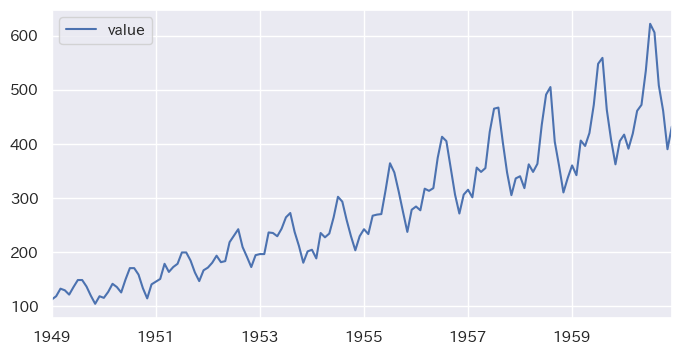

In [13]:
# 時系列折れ線グラフの作成
air_passengers.plot()

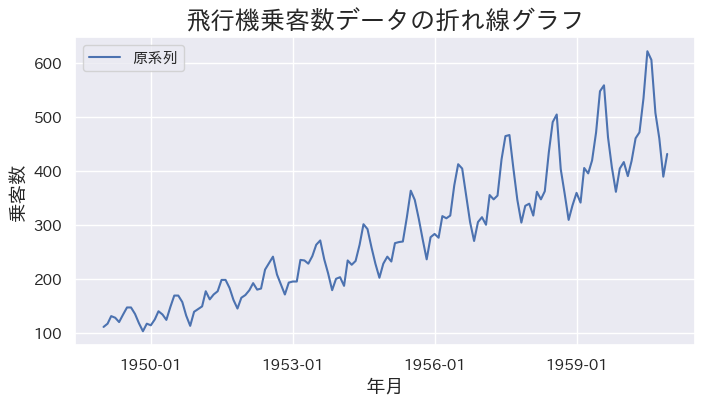

In [14]:
# ================================================
# 飛行機乗客数データの折れ線グラフの描画
# ================================================

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 折れ線グラフを描く
#   'value' 列に月ごとの乗客数が入っている
ax.plot(air_passengers["value"], label="原系列")

# 軸ラベルとタイトル・凡例
ax.set_xlabel("年月", size=14)  # x軸ラベル
ax.set_ylabel("乗客数", size=14)  # y軸ラベル
ax.set_title("飛行機乗客数データの折れ線グラフ", size=18)  # グラフタイトル
ax.legend()  # 凡例の表示

# ---- x軸（年月）の設定 ----
# 3年ごとに目盛りを表示（1949, 1952, 1955, …）
ax.xaxis.set_major_locator(mdates.YearLocator(3))

# 軸ラベルのフォーマットを「YYYY-MM」に設定
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

In [15]:
# データをコピー（元のデータを壊さないように別の変数に複製する）
air_passengers_lag = air_passengers.copy()

# 1時点（1か月）前のデータを「lag1」列として追加
# shift(1) は行を下方向に1つずらす → t の行に t-1 の値が入る
# 時系列解析でラグ変数（遅れ変数）を作る典型的な方法
air_passengers_lag["lag1"] = air_passengers_lag["value"].shift(1)

# 結果の確認（最初の3行）
# → 先頭行には1つ前のデータが存在しないので NaN が入る
print(air_passengers_lag.head(3))

# 結果の確認（最後の3行）
# → 最後の行には1つ先のデータがないので value のみ表示され、lag1 は1つ前の値になる
print(air_passengers_lag.tail(3))

            value   lag1
1949-01-01    112    NaN
1949-02-01    118  112.0
1949-03-01    132  118.0
            value   lag1
1960-10-01    461  508.0
1960-11-01    390  461.0
1960-12-01    432  390.0


In [16]:
# 2時点前のデータを「lag2」列として追加
# shift(2) → t の行に t-2 の値が入る
# つまり2か月前の乗客数を特徴量として作成
air_passengers_lag["lag2"] = air_passengers_lag["value"].shift(2)

# 逆に未来のデータを参照する例として「lead1」列を追加
# shift(-1) → t の行に t+1 の値が入る
# つまり1か月後の乗客数を列として作成（通常は分析では使わないが確認用）
air_passengers_lag["lead1"] = air_passengers_lag["value"].shift(-1)

# 結果の確認（最初の3行）
# → lag2 は最初の2行が NaN, lead1 は未来が存在しないので最後の行が NaN
print(air_passengers_lag.head(3))

# 結果の確認（最後の3行）
# → lag1, lag2 は直前や2つ前の値が入る
# → lead1 は最後の行が NaN になる
print(air_passengers_lag.tail(3))

            value   lag1   lag2  lead1
1949-01-01    112    NaN    NaN  118.0
1949-02-01    118  112.0    NaN  132.0
1949-03-01    132  118.0  112.0  129.0
            value   lag1   lag2  lead1
1960-10-01    461  508.0  606.0  390.0
1960-11-01    390  461.0  508.0  432.0
1960-12-01    432  390.0  461.0    NaN


In [17]:
# 差分値の計算
# 時系列データの「非定常性」を取り除くためによく行う処理
# 差分 = 当月の値 - 前月の値
# （例：1月の値 - 前月12月の値）
diff_value = air_passengers_lag["value"] - air_passengers_lag["value"].shift(1)

# 先頭3行を表示
# → 1行目は前月が存在しないため NaN
# → 2行目以降は実際の差分値が表示される
diff_value.head(3)

1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
Freq: MS, Name: value, dtype: float64

In [18]:
# データをコピー
# 元のデータを直接書き換えないように、新しいDataFrameを作成する
air_passengers_diff = air_passengers.copy()

# 差分系列を計算
# .diff(1) は「1期前との差」を計算する（＝1階差分）
# 時系列のトレンドを取り除き、定常化に近づけるためによく用いられる手法
air_passengers_diff["diff1"] = air_passengers_diff["value"].diff(1)

# 結果の確認
# 先頭3行を表示（最初の行は前の値がないのでNaNになる）
print(air_passengers_diff.head(3))

# 末尾3行を表示（終盤の差分がどのような値になっているか確認）
print(air_passengers_diff.tail(3))

            value  diff1
1949-01-01    112    NaN
1949-02-01    118    6.0
1949-03-01    132   14.0
            value  diff1
1960-10-01    461  -47.0
1960-11-01    390  -71.0
1960-12-01    432   42.0


In [19]:
# 季節差分を計算
# .diff(12) は「12期前との差」を計算する
# 今回のデータは月次データなので「12ヶ月前との差」＝「前年同月との差分」となる
# 季節性（毎年繰り返されるパターン）を取り除くために利用される
air_passengers_diff["diff12"] = air_passengers_diff["value"].diff(12)

<Axes: >

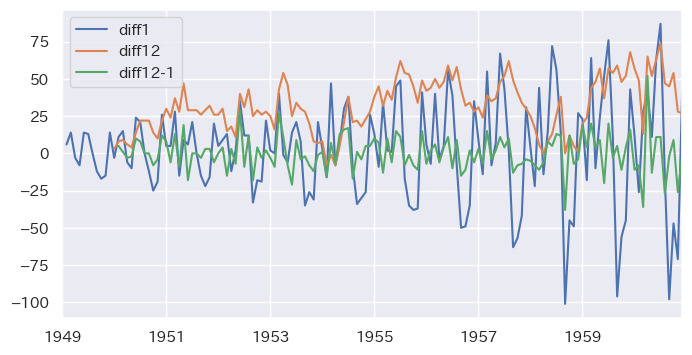

In [20]:
# 季節差分系列に対して、さらに1階差分をとる
# まず「12期前との差」（季節差分 diff12）を計算済み
# そこからさらに「1期前との差」を計算することで、季節性とトレンドの両方を取り除いた系列になる
# → ARIMAやSARIMAモデルの前処理でよく使われる
air_passengers_diff["diff12-1"] = air_passengers_diff["diff12"].diff(1)

# 時系列折れ線グラフを作成
# diff1     : 通常の1階差分（トレンド除去用）
# diff12    : 季節差分（前年同月との差）
# diff12-1  : 季節差分をさらに差分したもの（トレンド + 季節性を除去）
air_passengers_diff[["diff1", "diff12", "diff12-1"]].plot()

In [21]:
# 参考：差分をとる順番は関係ないことの確認
# diff12-1 : まず12期差分をとり、その後に1期差分をとったもの
# diff1-12 : まず1期差分をとり、その後に12期差分をとったもの
air_passengers_diff["diff1-12"] = air_passengers_diff["diff1"].diff(12)

# dropna() で NaN を除去した上で、両者が完全に一致するかをチェック
# True が返れば「差分の順番は関係ない」ということになる
all(
    air_passengers_diff["diff12-1"].dropna() == air_passengers_diff["diff1-12"].dropna()
)

True

<Axes: >

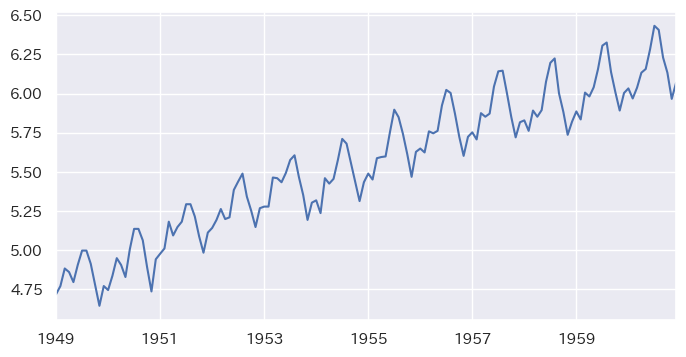

In [22]:
# データをコピー（元データを壊さないためにコピーを作成）
air_passengers_log = air_passengers.copy()

# 対数変換を行う
# - 時系列データでは、分散が大きくなる（変動幅が年月とともに大きくなる）ことが多い
# - 対数変換を使うと「変動の大きさを相対的に均一化」できる（分散安定化）
# - 予測モデル（ARIMAなど）においてもよく使われる前処理
air_passengers_log["log"] = air_passengers_log["value"].apply(np.log)

# 対数変換後の系列を折れ線グラフで描画
# 元の値と比較して「緩やかな右肩上がり」になることが確認できる
air_passengers_log["log"].plot()

In [23]:
# 対数変換をもとに戻す（逆変換）
# - np.exp は自然対数の逆関数（指数関数 e^x）
# - これにより対数変換前の元のスケールに戻せる
# - データの変換が正しく行われたか確認する際に使う
air_passengers_log["log"].apply(np.exp).head(3)

1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
Freq: MS, Name: log, dtype: float64

In [24]:
# 対数差分系列の作成
# - 対数を取った値に対して、1期（1か月）前との差分を計算
# - これによりデータのトレンド（長期的な上昇傾向）が除去される
air_passengers_log["log_diff1"] = air_passengers_log["log"].diff(1)

# 対数季節差分系列の作成
# - 対数を取った値に対して、12期（1年）前との差分を計算
# - これにより季節性（毎年繰り返すパターン）が除去される
air_passengers_log["log_diff12"] = air_passengers_log["log"].diff(12)

<Axes: >

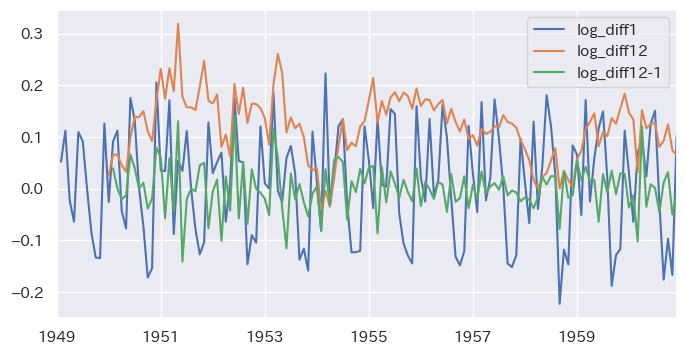

In [25]:
# 対数季節差分系列に対して、さらに通常の差分を取る
# - log_diff12: 季節性を除去した系列
# - その上で diff(1) を取ることで、残っているトレンド成分も除去
# - 「トレンド＋季節性」を取り除いた、より定常的な系列を得られる
air_passengers_log["log_diff12-1"] = air_passengers_log["log_diff12"].diff(1)

# 時系列折れ線グラフを描画
# - log_diff1: トレンドを除去した系列
# - log_diff12: 季節性を除去した系列
# - log_diff12-1: 季節性を除去した上でさらに差分を取り、定常性を高めた系列
air_passengers_log[["log_diff1", "log_diff12", "log_diff12-1"]].plot()

In [26]:
# 自己相関係数（Autocorrelation Function: ACF）の計算
# nlags=12 として、ラグ0からラグ12までの自己相関係数を算出する
# 自己相関係数は「時系列がどの程度自己相関を持つか（過去の値と現在の値がどの程度関係しているか）」を示す指標である
tsa.acf(air_passengers["value"], nlags=12)

array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542, 0.71376997,
       0.6817336 , 0.66290439, 0.65561048, 0.67094833, 0.70271992, 0.74324019,
       0.76039504])

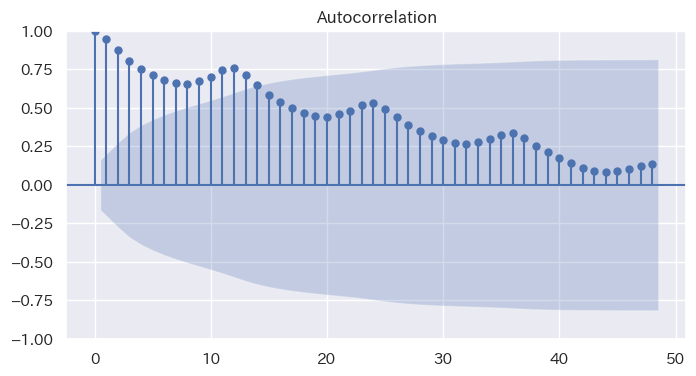

In [27]:
# コレログラム（自己相関関数のグラフ）の作成
# lags=48 として、ラグ0からラグ48までの自己相関係数を可視化する
# 縦の点線（青色の帯）は「有意水準の95%信頼区間」を表しており、
# 棒グラフがこの帯を超えている場合、そのラグで有意な自己相関があると判断できる
_ = sm.graphics.tsa.plot_acf(air_passengers["value"], lags=48)

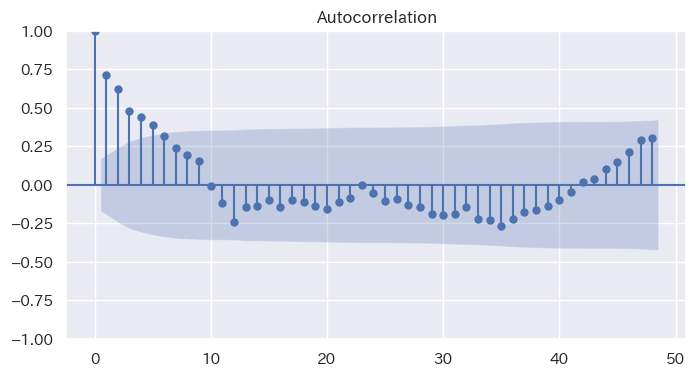

In [28]:
# 対数差分系列（12ヶ月の季節差分）のコレログラム
# dropna() で先頭の NaN を除去している
# lags=48 として、最大48ラグ先までの自己相関を表示する
# 季節差分を取ったため、元の系列に見られた強いトレンドや季節性は弱まり、
# より「定常的」な自己相関パターンを観察できる
_ = sm.graphics.tsa.plot_acf(air_passengers_log["log_diff12"].dropna(), lags=48)

<Axes: xlabel='value', ylabel='value'>

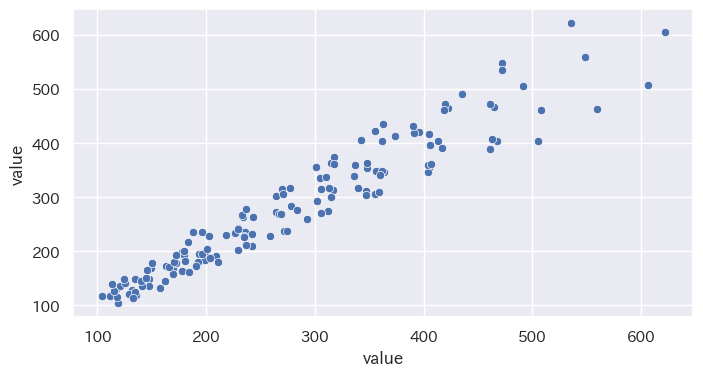

In [29]:
# 正の自己相関のイメージを可視化する散布図
# x軸には1期前（lag=1）の乗客数、y軸には当期の乗客数を配置する
# もし系列が強い正の自己相関を持つなら、点は右上がりの直線に近い分布になる
sns.scatterplot(
    x=air_passengers["value"].shift(1),  # 1期前の値
    y=air_passengers["value"],  # 現在の値
)

<Axes: xlabel='log_diff12', ylabel='log_diff12'>

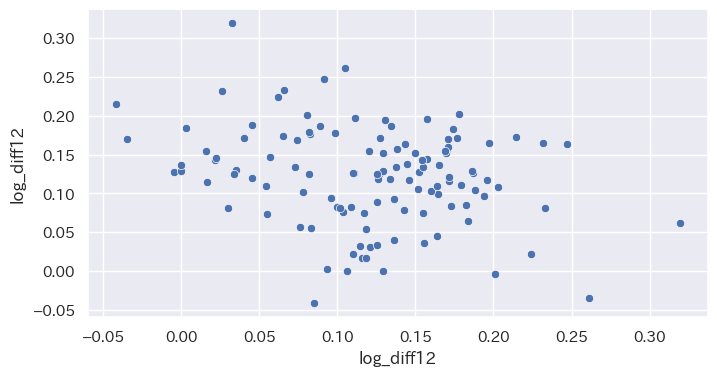

In [30]:
# 負の自己相関のイメージを可視化する散布図
# x軸には12期前（ラグ=12）の対数差分系列の値、
# y軸には当期の対数差分系列の値を配置する。
# 負の自己相関がある場合、点は右下がりの直線に近い分布を示す。
sns.scatterplot(
    x=air_passengers_log["log_diff12"].shift(12),  # 12期前の値
    y=air_passengers_log["log_diff12"],  # 現在の値
)

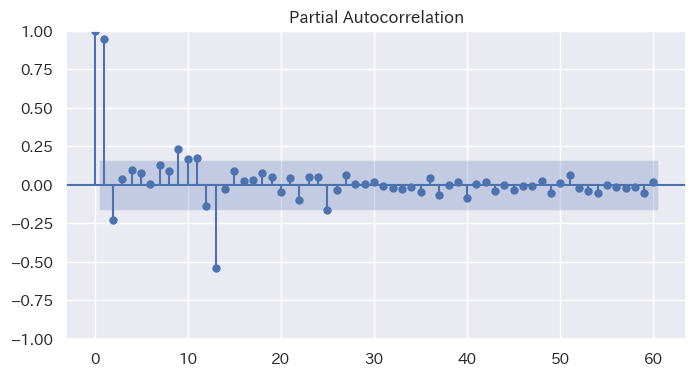

In [31]:
# 偏自己相関係数のコレログラム（Partial Autocorrelation Function: PACF）
# plot_pacfを使うと、あるラグにおける自己相関が、
# それ以前のラグの影響を取り除いた「純粋な相関」として計算される。
# - lags=60: 60期（60か月 = 5年間）までのラグを表示
# - method='ywm': Yule-Walker方程式に基づく推定方法を指定
_ = sm.graphics.tsa.plot_pacf(
    air_passengers["value"],  # 元データ
    lags=60,  # ラグの最大数
    method="ywm",  # 偏自己相関の推定方法
)

In [32]:
# データをコピー
air_passengers_ma = air_passengers.copy()
# → 元の飛行機乗客数データを複製して、新しいDataFrameに保存する。
#   （元データを上書きしないようにするため）

# 5時点の移動平均
air_passengers_ma["ma5"] = air_passengers_ma["value"].rolling(window=5).mean()
# → 「過去5期間（5か月）」のデータを使って平均を算出する。
#   例：5月の平均値は1月〜5月の平均。
#   → トレンドの滑らかな動きを捉える（短期変動を除去）。

# 5時点の移動平均において、当該時点を中心にする
air_passengers_ma["ma5_center"] = (
    air_passengers_ma["value"].rolling(window=5, center=True).mean()
)
# → 同じく5期間の移動平均だが、「中心」を現在の月に合わせて平均を計算する。
#   例：5月の平均値は3月〜7月の平均。
#   → よりトレンドを対称的に滑らかに表す。

# 結果の確認
print(air_passengers_ma.head(6))
# → 最初の6行を表示して、移動平均の計算結果を確認。
#   最初の数行は欠損値（NaN）になる（5期間分そろわないため）。

            value    ma5  ma5_center
1949-01-01    112    NaN         NaN
1949-02-01    118    NaN         NaN
1949-03-01    132    NaN       122.4
1949-04-01    129    NaN       127.0
1949-05-01    121  122.4       133.0
1949-06-01    135  127.0       136.2


In [ ]:
# 4時点移動平均
air_passengers_ma["ma4_center"] = (
    air_passengers_ma["value"].rolling(window=4, center=True).mean()
)
# → 「4期間（4か月）」のデータを使って移動平均を算出する。
#   'center=True' により、現在の時点を中心に2期間前〜1期間後の値を平均化。
#   例：4月の値は「2月・3月・4月・5月」の平均になる。
#   → 偶数期間の移動平均では、結果が時系列上で半期間ずれる傾向がある。

# 移動平均結果を確認
print(air_passengers_ma[["value", "ma4_center"]].head(4))
# → データの先頭4行を表示して、最初の部分の平均値が計算されているか確認。
#   最初の2行ほどはデータが足りないため NaN になる。

print(air_passengers_ma[["value", "ma4_center"]].tail(4))
# → データの末尾4行を表示して、終盤の平均値も正しく算出されているか確認。
#   同様に最後の数点は NaN になる（平均に必要なデータが不足するため）。

            value  ma4_center
1949-01-01    112         NaN
1949-02-01    118         NaN
1949-03-01    132      122.75
1949-04-01    129      125.00
            value  ma4_center
1960-09-01    508      549.25
1960-10-01    461      491.25
1960-11-01    390      447.75
1960-12-01    432         NaN


In [34]:
# 加重移動平均（Weighted Moving Average）に使う重みを設定
weight = np.concatenate(
    [
        np.array([1 / 8]),  # 端（最初と最後）のデータ点には1/8の重み
        np.tile(1 / 4, 3),  # 中央の3点にはそれぞれ1/4の重み
        np.array([1 / 8]),  # 末端にも同じく1/8の重み
    ]
)
# → 合計が 1 になるように設計された5点対称の重みベクトル。
#   中心付近のデータを重視し、外側のデータの影響を小さくする。

weight
# → 設定した重みベクトルを表示して確認する。
#   出力例: [0.125 0.25  0.25  0.25  0.125]

array([0.125, 0.25 , 0.25 , 0.25 , 0.125])

In [35]:
# 1949年3月（中央の月）における加重移動平均値を計算

# np.average()関数では、データと重み（weights）を指定して平均を計算できる。
# ここでは1949年1月〜5月の5か月分のデータを対象に、先ほど定義した重みを使用。
# → 中央（3月）のデータに近い月を重視し、遠い月の影響を小さくしている。

np.average(
    air_passengers_ma["value"].loc["1949-01":"1949-05"],  # 対象期間のデータ
    weights=weight,  # 加重平均の重み
)
# 結果：1949年3月の「平滑化された」乗客数（移動平均値）が得られる。
# 時系列データの短期的な変動を抑えて、全体の傾向を捉える目的で用いる。

123.875

In [36]:
# 加重移動平均（Weighted Moving Average）を全期間にわたって計算する

# rolling(window=5, center=True):
#   - 過去2時点・未来2時点・現在の合計5時点を1つの窓として処理する。
#   - center=Trueにより、「中央の観測点」に対して移動平均を対応付ける。
#
# apply(np.average, kwargs={'weights': weight}):
#   - 各窓（5時点）に対して、np.average()を用いて加重平均を計算する。
#   - weights=weightで、あらかじめ設定した重みを適用。
#     （例：中央の観測点を重く、端の観測点を軽くする）
#
# 結果：
#   - true_ma4 には、時系列全体にわたる加重移動平均系列が格納される。
#   - NaN は、最初と最後の数点（窓の外にデータがない部分）に発生する。

true_ma4 = (
    air_passengers_ma["value"]
    .rolling(window=5, center=True)
    .apply(np.average, kwargs={"weights": weight})
)

# 計算結果の先頭5件を確認
true_ma4.head(5)

1949-01-01        NaN
1949-02-01        NaN
1949-03-01    123.875
1949-04-01    127.125
1949-05-01    131.250
Freq: MS, Name: value, dtype: float64

In [37]:
# 単純な4期移動平均に対して、さらに移動平均を適用する（二重移動平均）

# 目的：
#   - 「移動平均の移動平均」をとることで、データの変動をより滑らかにする。
#   - 季節性の影響を抑え、長期的なトレンドを明確にする手法。

# 手順の詳細：
#   ① air_passengers_ma['ma4_center']:
#        先ほど計算した「中心化4期移動平均」列を対象とする。
#   ② rolling(window=2):
#        2期（直近2つの移動平均）をまとめて平均する。
#   ③ mean():
#        各2期の平均値を計算。
#   ④ shift(-1):
#        平均を「中央の時点」に合わせるため、1期分前方へシフトする。
#        これにより、時間的な整合性が保たれる。

air_passengers_ma["true_ma4"] = (
    air_passengers_ma["ma4_center"].rolling(window=2).mean().shift(-1)
)

# 計算結果の先頭と末尾を確認
print(air_passengers_ma.head(4))  # 先頭4行（NaNが多く含まれる）
print(air_passengers_ma.tail(4))  # 末尾4行（最終時点までの傾向を確認）

            value  ma5  ma5_center  ma4_center  true_ma4
1949-01-01    112  NaN         NaN         NaN       NaN
1949-02-01    118  NaN         NaN         NaN       NaN
1949-03-01    132  NaN       122.4      122.75   123.875
1949-04-01    129  NaN       127.0      125.00   127.125
            value    ma5  ma5_center  ma4_center  true_ma4
1960-09-01    508  548.6       517.4      549.25    520.25
1960-10-01    461  546.4       479.4      491.25    469.50
1960-11-01    390  517.4         NaN      447.75       NaN
1960-12-01    432  479.4         NaN         NaN       NaN


In [38]:
# 参考：2つの方法で求めた中心化移動平均（true_ma4）の一致確認

# 目的：
#   - 「二重移動平均」で求めた結果（air_passengers_ma['true_ma4']）と、
#     「重み付き移動平均（加重平均）」で求めた結果（true_ma4）が
#     一致しているかを確認する。

# 手順：
#   ① dropna()：
#        NaNを除外して比較を正確に行う。
#   ② == :
#        各時点ごとに2つのSeriesの値が等しいか（True/False）を確認。
#   ③ **2 :
#        論理値（True/False）を数値化（True=1, False=0）し、
#        平方することで全てTrue（1）なら完全一致を示す。
#   ④ np.all():
#        全要素がTrueならTrueを返す（＝すべて一致）。

# 結果：
#   - True → 2つの手法による結果が完全に一致している。
#   - False → 計算精度や端点処理で差異がある。

np.all((air_passengers_ma["true_ma4"].dropna() == true_ma4.dropna()) ** 2)

True

<Axes: >

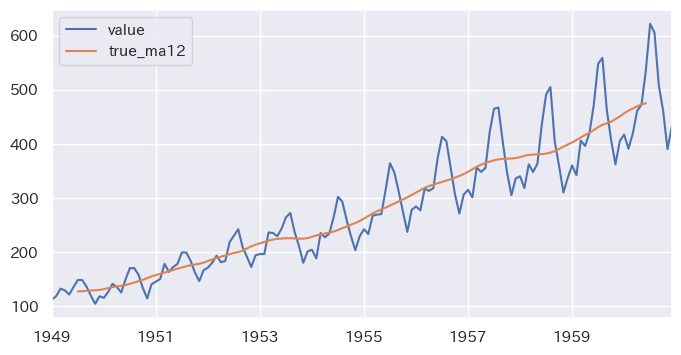

In [39]:
# 12時点中心化移動平均（トレンド抽出）の実装

# 目的：
#   月次の変動が大きい「飛行機乗客数データ」から、
#   長期的なトレンド（滑らかな変化）を取り出す。

# 処理手順：
# -------------------------------------------------------
# ① 12時点単純移動平均（ma12_center）：
#     - 各月を中心として前後6か月を含む12か月分の平均を計算。
#     - 季節的な周期をおおまかに平滑化する。

# ② 二重移動平均（true_ma12）：
#     - 12時点移動平均(ma12_center)に対してさらに2時点の移動平均を計算。
#     - shift(-1)で時系列の中心を揃え、「中心化移動平均」を実現。
#     - これにより、より正確なトレンド線を得る。

# ③ 可視化：
#     - 原系列（value）と中心化12時点移動平均（true_ma12）を比較。
#     - 季節変動をならした長期傾向を視覚的に確認できる。

air_passengers_ma["ma12_center"] = (
    air_passengers_ma["value"].rolling(window=12, center=True).mean()
)

air_passengers_ma["true_ma12"] = (
    air_passengers_ma["ma12_center"].rolling(window=2).mean().shift(-1)
)

# 原系列と12時点中心化移動平均の比較をプロット
air_passengers_ma[["value", "true_ma12"]].plot()

In [40]:
# 月ごとの気象データ（例：平均気温・降水量など）の読み込みと確認

# 目的：
#   時系列解析の対象となる月次データを読み込み、
#   Pandas の DateTimeIndex として正しく扱えるよう整形する。

# 処理内容：
# -------------------------------------------------------
# ① CSVファイルを読み込む：
#     - ファイル名：'2-5-1-weather-month.csv'
#     - '年月'列を時系列のインデックス（index_col）として使用。
#     - parse_dates=True により、年月を日付型（datetime64）に自動変換。
#     - dtype='float' により数値データとして読み込み。

# ② 時系列の頻度を明示的に指定：
#     - freq='MS' は「Month Start（各月の初日）」を意味する。
#     - これにより、Pandas が自動的に月単位の周期性を理解できる。

# ③ データ確認：
#     - head(3)：最初の3行を表示。
#     - tail(3)：最後の3行を表示。
#     - データの構造とインデックスの整合性を確認する。

weather_month = pd.read_csv(
    "2-5-1-weather-month.csv",  # 月次気象データ
    index_col="年月",  # '年月'列をインデックスに指定
    parse_dates=True,  # 日付型に変換
    dtype="float",  # 数値型として読み込み
)

# 月初日（MS: Month Start）をインデックスの頻度として指定
weather_month.index.freq = "MS"

# データの冒頭と末尾を表示して確認
print(weather_month.head(3))
print(weather_month.tail(3))

            平均気温(℃)  日最高気温35℃以上日数(日)
年月                                              
1900-01-01          1.6                        0.0
1900-02-01          3.1                        0.0
1900-03-01          5.7                        0.0
            平均気温(℃)  日最高気温35℃以上日数(日)
年月                                              
2021-10-01         18.2                        0.0
2021-11-01         13.7                        0.0
2021-12-01          7.9                        0.0


<Axes: xlabel='年月'>

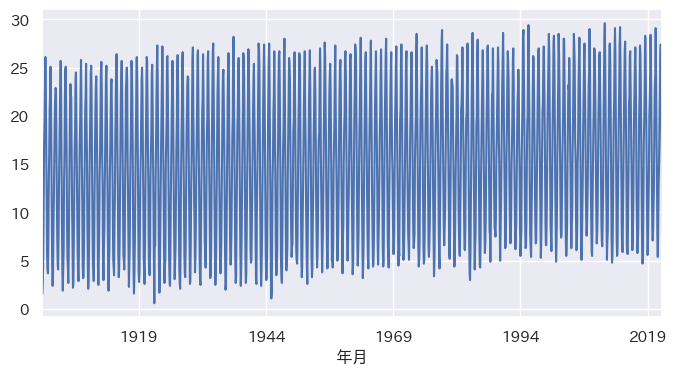

In [41]:
weather_month["平均気温(℃)"].plot()

In [42]:
# 年ごとの「35℃以上の日数」の集計

# 目的：
#   - 月次データ（weather_month）から、
#     年単位での「猛暑日（35℃以上の日数）」の合計を算出する。
#   - 年次単位の傾向（気候変動など）を確認できるようにする。

# 処理内容：
# -------------------------------------------------------
# ① resample('YS').sum()：
#     - 'YS' は「Year Start（各年の初日）」を意味する。
#     - つまり「年次単位」に再サンプリングを行い、月ごとの合計値を求める。
#     - sum() により、その年に発生した猛暑日数の総計を算出。

# ② drop('平均気温(℃)', axis=1)：
#     - 年ごとの合計には不要な「平均気温」列を削除。
#     - 年間集計の目的は「35℃以上日数」に絞る。

# ③ 出力確認：
#     - head(3)：最初の3年分を表示。
#     - tail(3)：最後の3年分を表示。
#     - 年単位に正しく集計されているかを確認。

# 結果：
#     各年における「35℃以上の日数」が表示される。

# 年次サンプリングによる集計
weather_year = weather_month.resample("YS").sum()

# 不要な平均気温列を削除
weather_year = weather_year.drop("平均気温(℃)", axis=1)

# 結果の確認（先頭3行と末尾3行）
print(weather_year.head(3))
print(weather_year.tail(3))

            日最高気温35℃以上日数(日)
年月                                 
1900-01-01                        1.0
1901-01-01                        1.0
1902-01-01                        0.0
            日最高気温35℃以上日数(日)
年月                                 
2019-01-01                       12.0
2020-01-01                       12.0
2021-01-01                        2.0


<Axes: title={'center': '日最高気温35℃以上日数'}, xlabel='年', ylabel='日数'>

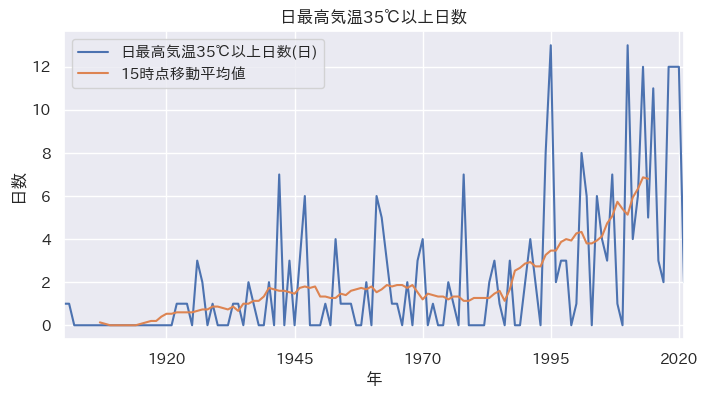

In [43]:
# 15時点（15年分）の移動平均を計算し、長期的な気温傾向を可視化する

# 処理の目的：
#   - 年ごとの「35℃以上日数」データから短期的な変動をならし、
#     長期的な気候変動の傾向（猛暑日の増減）を見やすくする。
#   - 移動平均は気候分析や時系列分析における代表的な平滑化手法である。

# 処理内容：
# -------------------------------------------------------
# ① rolling(window=15, center=True).mean():
#     - 「window=15」で15年間の移動平均を計算。
#     - 「center=True」により、移動平均を各期間の中央（7年目付近）に対応づける。
#     - これにより、トレンドが時間軸に対して自然に表示される。

# ② 新しい列名「15時点移動平均値」を追加：
#     - 平滑化後の結果を別列に保持し、元のデータと比較可能にする。

# ③ plot():
#     - 原系列（猛暑日数）と15年移動平均系列を重ねて折れ線グラフで描画。
#     - xlabel / ylabel / title により、日本語のラベルを付与して視覚的に理解しやすくする。

# 結果の解釈：
#     - 折れ線の細かな上下動：年ごとの猛暑日数のばらつき。
#     - 太く滑らかな線（移動平均）：長期的な気温上昇・下降の傾向を示す。

# -------------------------------------------------------

# 15年の中心化移動平均を計算
weather_year["15時点移動平均値"] = (
    weather_year["日最高気温35℃以上日数(日)"].rolling(window=15, center=True).mean()
)

# 折れ線グラフを描画（原系列と移動平均の比較）
weather_year[["日最高気温35℃以上日数(日)", "15時点移動平均値"]].plot(
    title="日最高気温35℃以上日数", xlabel="年", ylabel="日数"
)

<Axes: title={'center': '月平均気温の年間平均値'}, xlabel='年', ylabel='気温(℃)'>

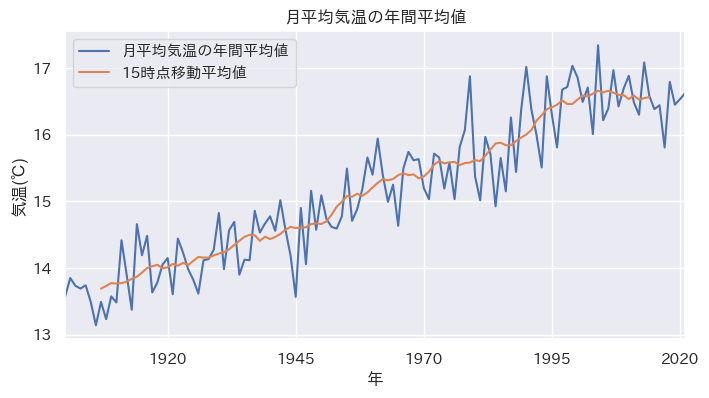

In [44]:
# 月平均気温データをもとに、年単位の平均気温とその長期的傾向を可視化するコード

# -------------------------------------------------------
# 処理の目的：
#   - 各年の「月平均気温」をまとめて年間平均を算出し、
#     気温変動の長期トレンド（温暖化など）を把握する。
#   - 移動平均を用いることで、短期的な気温変動を平滑化し、
#     気候変動の全体的な傾向を視覚的に明らかにする。

# 処理内容：
# -------------------------------------------------------
# ① 年ごとの「月平均気温の年間平均値」を算出
#     - weather_month['平均気温(℃)'] を利用。
#     - resample('YS').mean() により、年初を基準とした年単位の平均値を求める。
#       ※ 'YS' は “Year Start” の略で、年初ごとにデータをまとめる頻度指定。

# ② 15年移動平均の計算
#     - rolling(window=15, center=True).mean() を使い、
#       15年間の平均値を中央に配置する（中心化移動平均）。
#     - これにより長期トレンドを滑らかに表示可能。

# ③ グラフ描画
#     - 年ごとの平均気温と15年移動平均を同時にプロット。
#     - 横軸：年、縦軸：気温（℃）。
#     - タイトルおよび軸ラベルを日本語で指定。

# 結果の解釈：
#     - 細い折れ線：年ごとの気温変化を表す。
#     - 滑らかな線：長期的な温暖化または寒冷化の傾向を示す。
# -------------------------------------------------------

# 年間平均気温を計算
weather_year["月平均気温の年間平均値"] = (
    weather_month["平均気温(℃)"].resample("YS").mean()
)

# 15年中心化移動平均を計算
weather_year["15時点移動平均値"] = (
    weather_year["月平均気温の年間平均値"].rolling(window=15, center=True).mean()
)

# 折れ線グラフで気温変化を可視化
weather_year[["月平均気温の年間平均値", "15時点移動平均値"]].plot(
    title="月平均気温の年間平均値", xlabel="年", ylabel="気温(℃)"
)

<Axes: title={'center': '月平均気温の年間最大値'}, xlabel='年', ylabel='気温(℃)'>

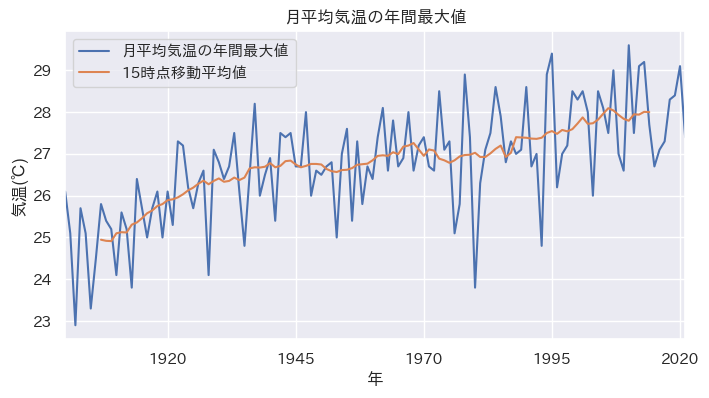

In [45]:
# -------------------------------------------------------
# 📊 月平均気温の年間「最大値」をもとに長期トレンドを分析するコード
# -------------------------------------------------------

# 処理の目的：
#   - 各年における「最も暑い月（平均気温が最大の月）」を抽出し、
#     年ごとの最高気温傾向を分析する。
#   - 短期的な年ごとのばらつきを平滑化するために、
#     15年間の中心化移動平均を算出して長期的な上昇傾向を確認する。

# 処理手順：
# -------------------------------------------------------
# ① 年ごとの月平均気温の最大値を計算：
#     - weather_month['平均気温(℃)'] を対象に resample('YS').max() を実行。
#     - これにより「その年の中で最も暑い月の平均気温」が得られる。

# ② 15年中心化移動平均を計算：
#     - rolling(window=15, center=True).mean() により、
#       15年間の平均値を「中央」に配置して平滑化。
#     - 年ごとのばらつきを除去し、長期的な温暖化傾向を把握。

# ③ 可視化：
#     - 原系列（年ごとの最大月平均気温）と移動平均を重ねて描画。
#     - タイトルに「月平均気温の年間最大値」と明示し、
#       長期的な気候変動を視覚的に理解できるようにする。

# 結果の読み方：
#     - 折れ線（青）：各年の「最も暑い月の平均気温」。
#     - 平滑線（オレンジ）：15年単位の長期的な気温上昇傾向。
# -------------------------------------------------------

# 年ごとの最大月平均気温を算出
weather_year["月平均気温の年間最大値"] = (
    weather_month["平均気温(℃)"].resample("YS").max()
)

# 15年中心化移動平均を算出
weather_year["15時点移動平均値"] = (
    weather_year["月平均気温の年間最大値"].rolling(window=15, center=True).mean()
)

# 折れ線グラフで比較表示
weather_year[["月平均気温の年間最大値", "15時点移動平均値"]].plot(
    title="月平均気温の年間最大値", xlabel="年", ylabel="気温(℃)"
)

<Axes: title={'center': '月平均気温の年間最小値'}, xlabel='年', ylabel='気温(℃)'>

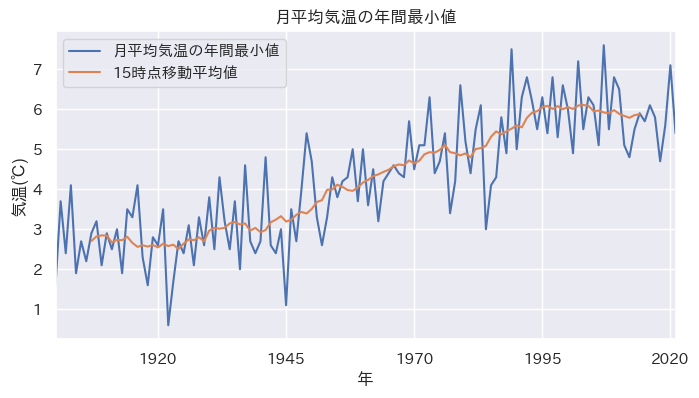

In [46]:
# -------------------------------------------------------
# 🌡️ 月平均気温の年間「最小値」をもとに寒冷傾向を分析するコード
# -------------------------------------------------------

# 処理の目的：
#   - 各年における「最も寒い月（平均気温が最も低い月）」を抽出し、
#     年ごとの寒冷傾向を分析する。
#   - 短期的な変動を平滑化し、長期的な寒暖の推移を確認する。

# 処理手順：
# -------------------------------------------------------
# ① 年ごとの月平均気温の最小値を算出：
#     - weather_month['平均気温(℃)'] を対象に resample('YS').min() を実行。
#     - これにより「その年で最も寒い月の平均気温」が得られる。
#       （例：1月や2月のような冬季の平均値）

# ② 15年中心化移動平均を計算：
#     - rolling(window=15, center=True).mean() により、
#       15年間の平均値を中央に配置して平滑化。
#     - 短期的な寒波・暖冬の影響を除き、気候変動の長期トレンドを確認できる。

# ③ 可視化：
#     - 折れ線グラフで「最小気温の年次推移」と
#       「15年移動平均線」を重ねて表示。
#     - タイトル「月平均気温の年間最小値」で、
#       どのような観測を示しているかを明確化。

# 結果の読み方：
#     - 青線：各年の「最も寒い月の平均気温」。
#     - オレンジ線：15年単位の寒冷傾向の変化。
#     - 全体的に上昇傾向であれば、冬の寒さが和らいでいることを意味する。
# -------------------------------------------------------

# 年ごとの最小月平均気温を算出
weather_year["月平均気温の年間最小値"] = (
    weather_month["平均気温(℃)"].resample("YS").min()
)

# 15年中心化移動平均を算出
weather_year["15時点移動平均値"] = (
    weather_year["月平均気温の年間最小値"].rolling(window=15, center=True).mean()
)

# 折れ線グラフで比較表示
weather_year[["月平均気温の年間最小値", "15時点移動平均値"]].plot(
    title="月平均気温の年間最小値", xlabel="年", ylabel="気温(℃)"
)